In [2]:
import os 
from random import choice
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# import albumentations as A
# from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as tt

from dataset import *
from segUtils import *
#from models import UNET
from unetModel import UnetModel

In [3]:
cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda


In [5]:
datapath = r"D:\programing\DataSets\segmentain\CamVid"
dataset_path = Path(datapath)
train_pairs, val_pairs, test_pairs = get_data_pairs(dataset_path)
class_map = get_class_map(dataset_path)
num_classes = len(class_map)
image_size=(128, 128)

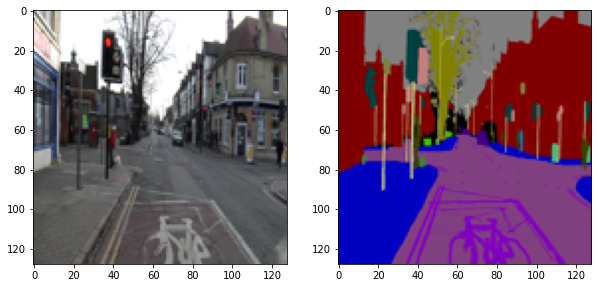

In [6]:
temp = choice(train_pairs)
img = np.array(Image.open(temp[0]).convert("RGB").resize(image_size))
mask = np.array(Image.open(temp[1]).convert("RGB").resize(image_size))
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img/255)
plt.subplot(122)
plt.imshow(mask/255)

In [7]:
transforms = tt.Compose([tt.ToTensor()])

In [8]:
from timeit import default_timer as timer
from datetime import timedelta

# helper functions

In [9]:
def make_prediction(model,img,transforms):
    model.eval()
    with torch.no_grad():
        img= transforms(img)
        img = img.unsqueeze(0)
        start = timer()
        preds = model(img)
        end = timer()
        preds = preds.cpu().detach().numpy()
        preds = np.transpose( preds, (0,2,3,1))
        preds = np.argmax(preds[0],axis=2)

    print(end-start)
    return preds

In [10]:
def image_form_colormap(prediction,mapping):
    h,w = prediction.shape
    color_label = np.zeros((h,w,3),dtype=np.uint8)    
    color_label = mapping[prediction]
    color_label = color_label.astype(np.uint8)
    return color_label

In [11]:
def plot_seg_result(img, gt_img, pred_colored):
    plt.figure(figsize=(15,15))
    plt.subplot(131)
    plt.title('Original Image')
    plt.imshow(img/255.)
    plt.subplot(132)
    plt.title('True labels')
    plt.imshow(gt_img/255.)
    plt.subplot(133)
    plt.imshow(pred_colored/255.)
    plt.title('predicted labels')

# load model

In [12]:
model = UnetModel(3, num_classes, [64, 128, 256, 512])
optimizer = optim.Adam(model.parameters(), lr=0.001)
chackpoint_file = dataset_path/"model_chackpoints/best_model.pb"
load_checkpoint(chackpoint_file, model, optimizer, 0.001, device)

=> Loading checkpoint


# make Predictions

0.3471175000000102


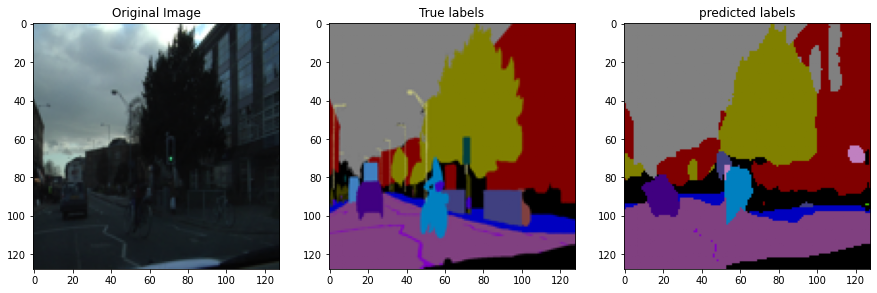

In [13]:
for _ in range(1):
    img_mask = choice(val_pairs)
    img= np.array(Image.open(img_mask[0]).convert("RGB").resize(image_size))
    gt_img = np.array(Image.open(img_mask[1]).convert("RGB").resize(image_size))
    preds = make_prediction(model, img, transforms)
    pred_colored = image_form_colormap(preds,np.array(class_map))
    plot_seg_result(img, gt_img, pred_colored)